In [ ]:
%pip install ultralytics
%pip install roboflow
%pip install tensorboard
%pip install opencv-python

In [1]:
import numpy as np 
import pandas as pd

In [2]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [4]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 200

In [5]:
type(EPOCHS)

int

In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="0Dp7b4BCzptuPaCQXRPQ")
project = rf.workspace("webuiproject").project("ui-screenshots")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.163, to fix: `pip install ultralytics==8.0.134`


Extracting Dataset Version Zip to UI-screenshots-1 in yolov8:: 100%|██████████| 3612/3612 [00:00<00:00, 12700.11it/s]


In [6]:
# define number of classes based on YAML
import yaml
with open("./UI-screenshots-1" + "/data.yaml", 'r') as stream:
    data = yaml.safe_load(stream)
    num_classes = str(data['nc'])
    class_names = list(data['names'])
num_classes
class_names

['button', 'field', 'heading', 'iframe', 'image', 'label', 'link', 'text']

In [7]:
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [8]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [10]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                bbox_values = bbox_string.split(' ')
                bbox_values = list(filter(None, bbox_values))  # Remove empty strings from the list
                x_c, y_c, w, h = map(float, bbox_values)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

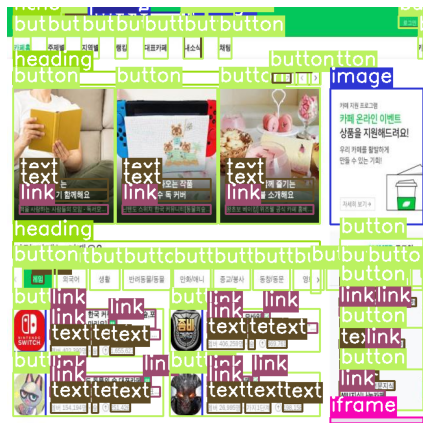

In [11]:
# Visualize a few training images.
plot(
    image_paths='./UI-screenshots-1/train/images/*',
    label_paths='./UI-screenshots-1/train/labels/*',
    num_samples=1,
)

In [12]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_yolov8m_{EPOCHS}_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_yolov8m_{EPOCHS}_{res_dir_count}"
    return RES_DIR

In [13]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/detect

In [15]:
# Install the ultralytics package using pip
#!pip install ultralytics

In [14]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.163 🚀 Python-3.9.12 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)
Setup complete ✅ (8 CPUs, 62.6 GB RAM, 1082.6/3664.8 GB disk)


In [15]:
monitor_tensorboard()

In [16]:
RES_DIR = set_res_dir()

Current number of result directories: 4
results_yolov8m_300_5


In [17]:
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8m.pt')
 
# Training.
results = model.train(
   data='./UI-screenshots-1/data.yaml',
   imgsz=640,
   epochs=EPOCHS,
   batch=8,
   name=RES_DIR
)

New https://pypi.org/project/ultralytics/8.0.173 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.163 🚀 Python-3.9.12 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=./UI-screenshots-1/data.yaml, epochs=300, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=results_yolov8m_300_5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, au

In [23]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/detect/{RES_DIR}
    EXP_PATH = f"runs/detect/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [24]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    # model = YOLO(f'runs/detect/{RES_DIR}/weights/best.pt')
    # model(source=data_path,name=INFER_DIR,show_labels=True)
    !yolo task=detect mode=predict model=runs/detect/{RES_DIR}/weights/best.pt \
    source={data_path} name={INFER_DIR}
    return INFER_DIR

In [25]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

args.yaml
confusion_matrix_normalized.png
confusion_matrix.png
events.out.tfevents.1694282510.lnx-n109-03.lunet.lboro.ac.uk.355238.0
F1_curve.png
labels_correlogram.jpg
labels.jpg
P_curve.png
PR_curve.png
R_curve.png
results.csv
results.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
weights
['runs/detect/results_yolov8m_300_5/val_batch1_pred.jpg', 'runs/detect/results_yolov8m_300_5/val_batch2_pred.jpg', 'runs/detect/results_yolov8m_300_5/val_batch0_pred.jpg']


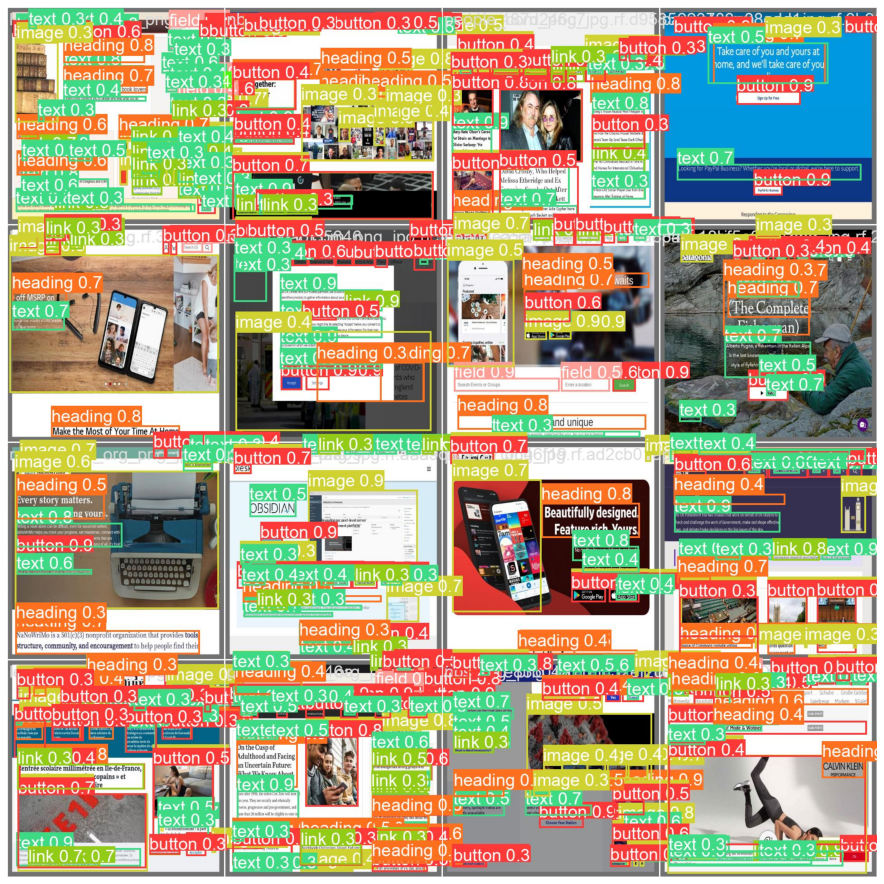

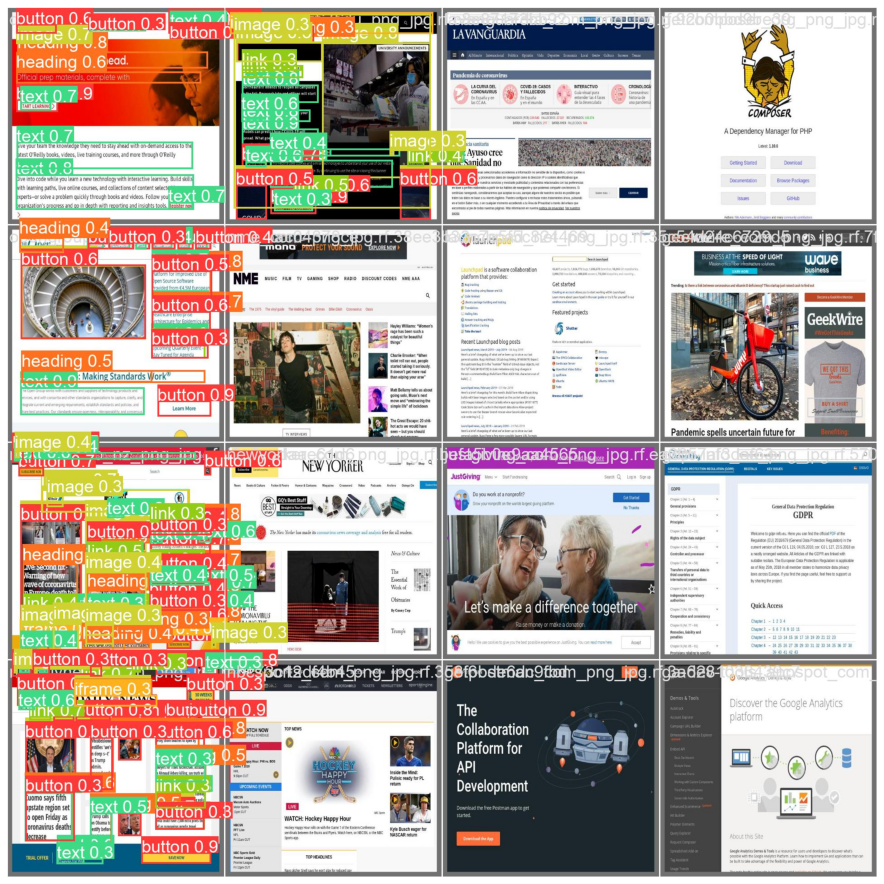

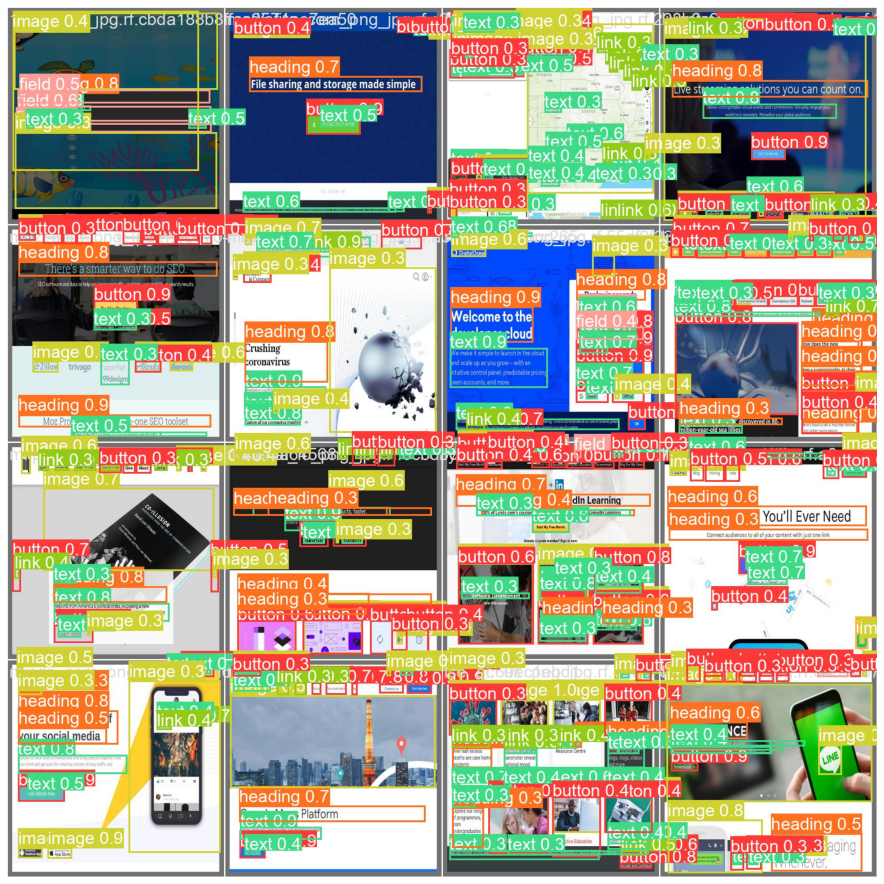

In [26]:
show_valid_results(RES_DIR)

In [ ]:
IMAGE_INFER_DIR

In [27]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, '/home/lunet/cospk/Documents/project1/UI-screenshots-2/test/images')

Current number of inference detection directories: 5
inference_6
Ultralytics YOLOv8.0.163 🚀 Python-3.9.12 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)
Model summary (fused): 218 layers, 25844392 parameters, 0 gradients, 78.7 GFLOPs

image 1/179 /home/lunet/cospk/Documents/project1/UI-screenshots-2/test/images/1025_png_jpg.rf.b9161a6d9a260f85ee7e39534d75e021.jpg: 640x640 13 buttons, 1 heading, 2 iframes, 3 images, 8 texts, 12.4ms
image 2/179 /home/lunet/cospk/Documents/project1/UI-screenshots-2/test/images/103_png_jpg.rf.d802ef5bc66dfddfb0a1f617819983d5.jpg: 640x640 1 button, 2 texts, 12.4ms
image 3/179 /home/lunet/cospk/Documents/project1/UI-screenshots-2/test/images/1044_png_jpg.rf.6b8b861950b12cbc2f2701e01a491f9e.jpg: 640x640 3 buttons, 1 heading, 3 images, 2 labels, 3 texts, 12.3ms
image 4/179 /home/lunet/cospk/Documents/project1/UI-screenshots-2/test/images/1045_png_jpg.rf.21758b32d9b8e27b12efb8b9ee959c19.jpg: 640x640 4 buttons, 1 heading, 1 image, 4 texts, 12.3m

In [96]:
visualize(IMAGE_INFER_DIR)

[]
